In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from urllib.request import urlopen
from io import BytesIO
import persistable
import hdbscan
import gudhi
from gudhi.clustering.tomato import Tomato
import persistable
import genieclust
from sklearn import metrics
import pandas as pd
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
import warnings

# Useful function

In [2]:
warnings.filterwarnings("ignore")
stat = pd.DataFrame(columns=['algo', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [3]:
stat = pd.DataFrame(columns=['algo', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])
def stat_filling(data, labels, algName, stat):
  row = {'algo' : algName,
         'silhouette' : metrics.silhouette_score(data, labels, metric='euclidean'),
         'calinski_harabasz' : metrics.calinski_harabasz_score(data, labels),
         'davies_bouldin' : metrics.davies_bouldin_score(data, labels)}
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)
  return stat

# Data preprocessing
Customer segmentation is a complicated task, which is commonly used to understand customer base and develop production and marketing strategies. First off, it is important to preprocess data by clearing incorrect inputs and removing outliers if their value is not important for business. 

In [4]:
df = pd.read_csv('customer_segmentation.csv')

In [5]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Missing values are filled with median value to avoid extreme effect of outliers.

In [6]:
median = df['Income'].median()
df['Income'].fillna(value=median, inplace=True)

In [7]:
df[['ID', 'Year_Birth', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']].corr()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,1.000000,0.000028,0.012996,0.002406,-0.002580,-0.046524,-0.022878,0.004600,-0.004437,-0.024475,...,-0.007446,-0.036040,-0.025387,-0.007517,-0.021614,-0.015061,0.033883,NaN,NaN,-0.021968
Year_Birth,0.000028,1.000000,-0.160899,0.230176,-0.352111,-0.019871,-0.157773,-0.017917,-0.030872,-0.041625,...,0.121139,0.061774,-0.060510,0.007123,-0.005930,-0.006539,-0.030128,NaN,NaN,0.021325
Income,0.012996,-0.160899,1.000000,-0.425326,0.018965,-0.004061,0.576903,0.428791,0.577805,0.437564,...,-0.549785,-0.016064,0.182718,0.334893,0.274891,0.087581,-0.027187,NaN,NaN,0.132867
Kidhome,0.002406,0.230176,-0.425326,1.000000,-0.036133,0.008827,-0.496297,-0.372581,-0.437129,-0.387644,...,0.447846,0.014674,-0.161600,-0.205634,-0.172339,-0.081716,0.040207,NaN,NaN,-0.080008
Teenhome,-0.002580,-0.352111,0.018965,-0.036133,1.000000,0.016198,0.004846,-0.176764,-0.261160,-0.204187,...,0.134884,-0.042677,0.038886,-0.191050,-0.140090,-0.015605,0.003138,NaN,NaN,-0.154446
Recency,-0.046524,-0.019871,-0.004061,0.008827,0.016198,1.000000,0.016064,-0.004306,0.023056,0.001079,...,-0.021445,-0.032991,0.018826,0.000129,-0.019283,-0.001781,0.013231,NaN,NaN,-0.198437
MntWines,-0.022878,-0.157773,0.576903,-0.496297,0.004846,0.016064,1.000000,0.389637,0.562667,0.399753,...,-0.320653,0.062202,0.373286,0.472613,0.354133,0.205907,-0.039007,NaN,NaN,0.247254
MntFruits,0.004600,-0.017917,0.428791,-0.372581,-0.176764,-0.004306,0.389637,1.000000,0.543105,0.594804,...,-0.418383,0.014727,0.010152,0.215833,0.194748,-0.009773,-0.005166,NaN,NaN,0.125289
MntMeatProducts,-0.004437,-0.030872,0.577805,-0.437129,-0.261160,0.023056,0.562667,0.543105,1.000000,0.568402,...,-0.539470,0.018272,0.102912,0.373769,0.309761,0.043033,-0.023483,NaN,NaN,0.236335
MntFishProducts,-0.024475,-0.041625,0.437564,-0.387644,-0.204187,0.001079,0.399753,0.594804,0.568402,1.000000,...,-0.446003,0.000357,0.016843,0.199578,0.260762,0.002577,-0.020953,NaN,NaN,0.111331


By investigating correlation matrix variables with highly correlated or constant values should be omitted.

In [8]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
df.drop(['ID', 'Response'], axis=1, inplace=True)

Variables can be grouped and encoded. Also, feature engineering may boost the performance.

In [9]:
df['Age'] = 2014 - df['Year_Birth']
df['Education'] = df['Education'].replace({"Basic":"1", "2n Cycle":"1", "Graduation":"2", "Master":"3", "PhD":"3"})
df['FamStatus'] = df['Marital_Status'].replace({"Married":"0", "Together":"0", "Absurd":"1", "Widow":"1", "YOLO":"1", "Divorced":"1", "Single":"1", 'Alone':"1"})
df['Kids'] = df['Kidhome'] + df['Teenhome']

In [10]:
df.drop(['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'FamStatus'], axis=1, inplace=True)

In [11]:
df = pd.get_dummies(df)

In [12]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(df)

# HDBSCAN

Clustering is an unsupervised learning task, thus, its hard to establish one metric, which will give superior clustering. To take into account both intercluster variation and variation between clusters, it is useful to create plots of Silhouette Score, Calinski-Harabasz score and Davies Bouldin score and find optimal combination. 

In [13]:
results_sil = dict()
results_cal = dict()
results_dav = dict()

In [14]:
for min_cluster_size in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
  for min_samples in [1, 5, 10, 15, 20, 25, 30]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, gen_min_span_tree=True)
    clusterer.fit(data)
    labels = clusterer.labels_
    print(min_cluster_size, min_samples)
    print(metrics.silhouette_score(data, labels, metric='euclidean'), metrics.calinski_harabasz_score(data, labels), metrics.davies_bouldin_score(data, labels))
    results_sil[min_cluster_size] = metrics.silhouette_score(data, labels, metric='euclidean')
    results_cal[min_cluster_size] = metrics.calinski_harabasz_score(data, labels)
    results_dav[min_cluster_size] = metrics.davies_bouldin_score(data, labels)

5 1
-0.02596554415135695 25.032975540264765 1.6935865888177404
5 5
0.08162384305293302 53.43702681277803 1.5269760286485123
5 10
0.0514557615717589 65.53598760132434 1.5717289731032917
5 15
0.053936890906835414 67.58414218016343 1.526123398170587
5 20
0.18748018101921987 71.5461431298367 2.0796001145634726
5 25
0.17452322109773735 66.44543306819732 2.351867544341715
5 30
0.16345911346538342 93.27249873077889 2.6260473421713275
10 1
0.08292971609102984 53.4001832033722 1.8123821562254314
10 5
0.08233838830338416 71.15397772975861 1.5999453606788212
10 10
0.0676460613960046 69.10649499566449 1.5290821172949367
10 15
0.053936890906835414 67.58414218016343 1.526123398170587
10 20
0.18748018101921987 71.5461431298367 2.0796001145634726
10 25
0.17689955105060876 92.45230938246635 2.667542346245758
10 30
0.16345911346538342 93.27249873077889 2.6260473421713275
15 1
0.08251268100625835 71.89977212921362 1.9302131031924936
15 5
0.07805984704578034 73.45525797473073 1.6353290598173424
15 10
0.07

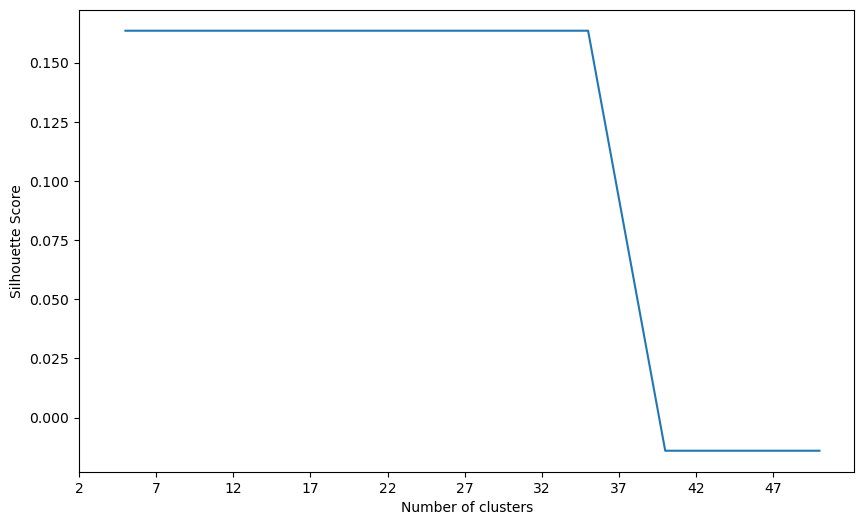

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_sil.keys()), list(results_sil.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 50, step = 5))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

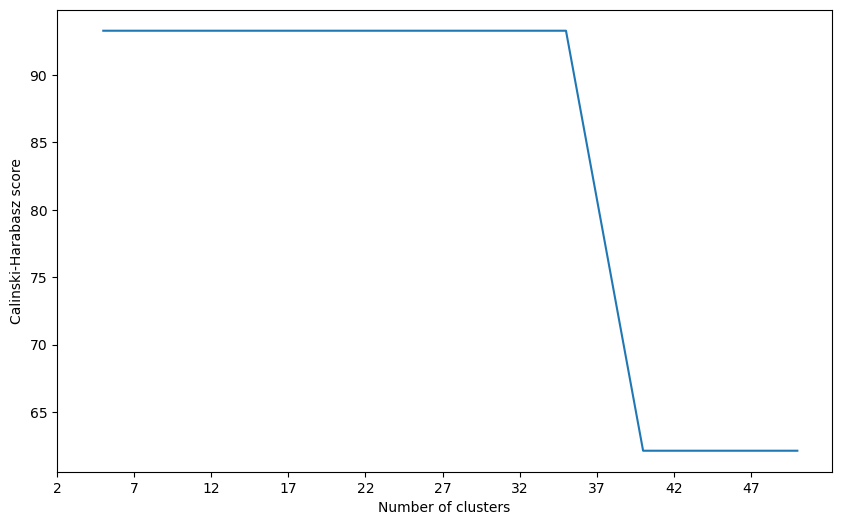

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_cal.keys()), list(results_cal.values()), label = 'calinski_harabasz_score')

plt.xticks(np.arange(2, 50, step = 5))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

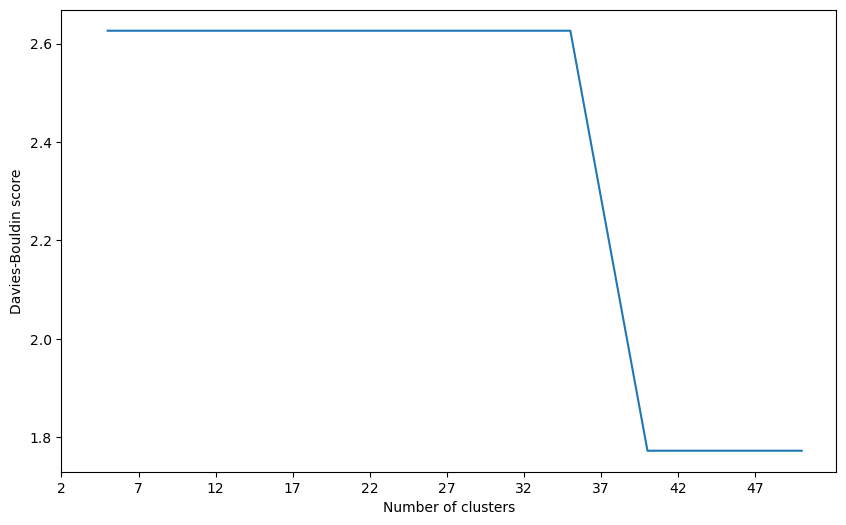

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_dav.keys()), list(results_dav.values()), label = 'davies_bouldin_score')

plt.xticks(np.arange(2, 50, step = 5))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin score')
plt.show()

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=25, gen_min_span_tree=True)
clusterer.fit(data)
labels = clusterer.labels_
print("silhouette_score", metrics.silhouette_score(data, labels, metric='euclidean'))
print("calinski_harabasz_score", metrics.calinski_harabasz_score(data, labels))
print("davies_bouldin_score", metrics.davies_bouldin_score(data, labels))

silhouette_score 0.17689955105060876
calinski_harabasz_score 92.45230938246635
davies_bouldin_score 2.667542346245758


This example shows high-dimensional data. Thus, to show results on a plot some transformation should be applied. Here TSNE is used.

In [19]:
model = TSNE()
projection = model.fit_transform(data)

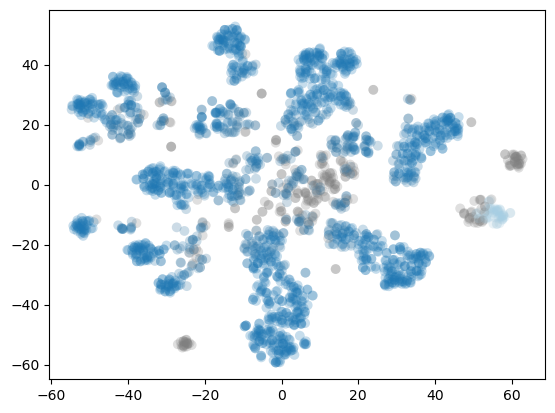

In [20]:
color_palette = sns.color_palette('Paired', 15)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25);
stat = stat_filling(data, clusterer.labels_, 'HDBSCAN', stat)

# ToMATo

ToMATo original paper suggest to conduct several tests and consider changes at persistence diagram.

There are 98 initial clusters


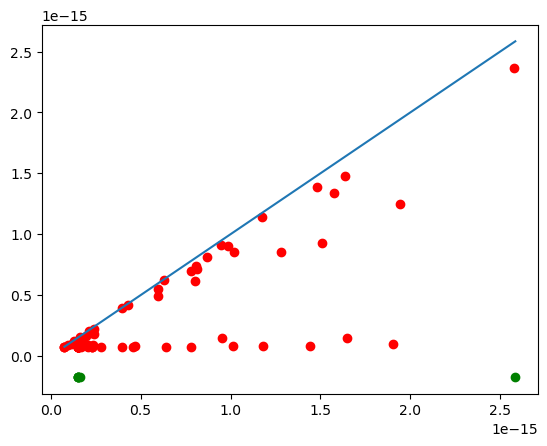

In [21]:
clusterer = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="knn",
        density_type="KDE",
        k=7,
        eps=0.05
    )

clusterer.fit(data)

print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()

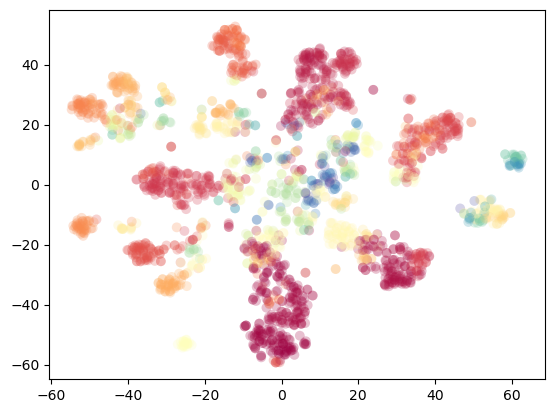

In [22]:
color_palette = sns.color_palette('Paired', 100)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
n = clusterer.n_clusters_
labels = clusterer.labels_
norm = plt.Normalize(vmin=0, vmax=n-1)
cmap = plt.cm.Spectral;
plt.scatter(*projection.T, s=50, linewidth=0, c=cmap(norm(labels)), alpha=0.25);
stat = stat_filling(data, clusterer.labels_, 'ToMATo1', stat)

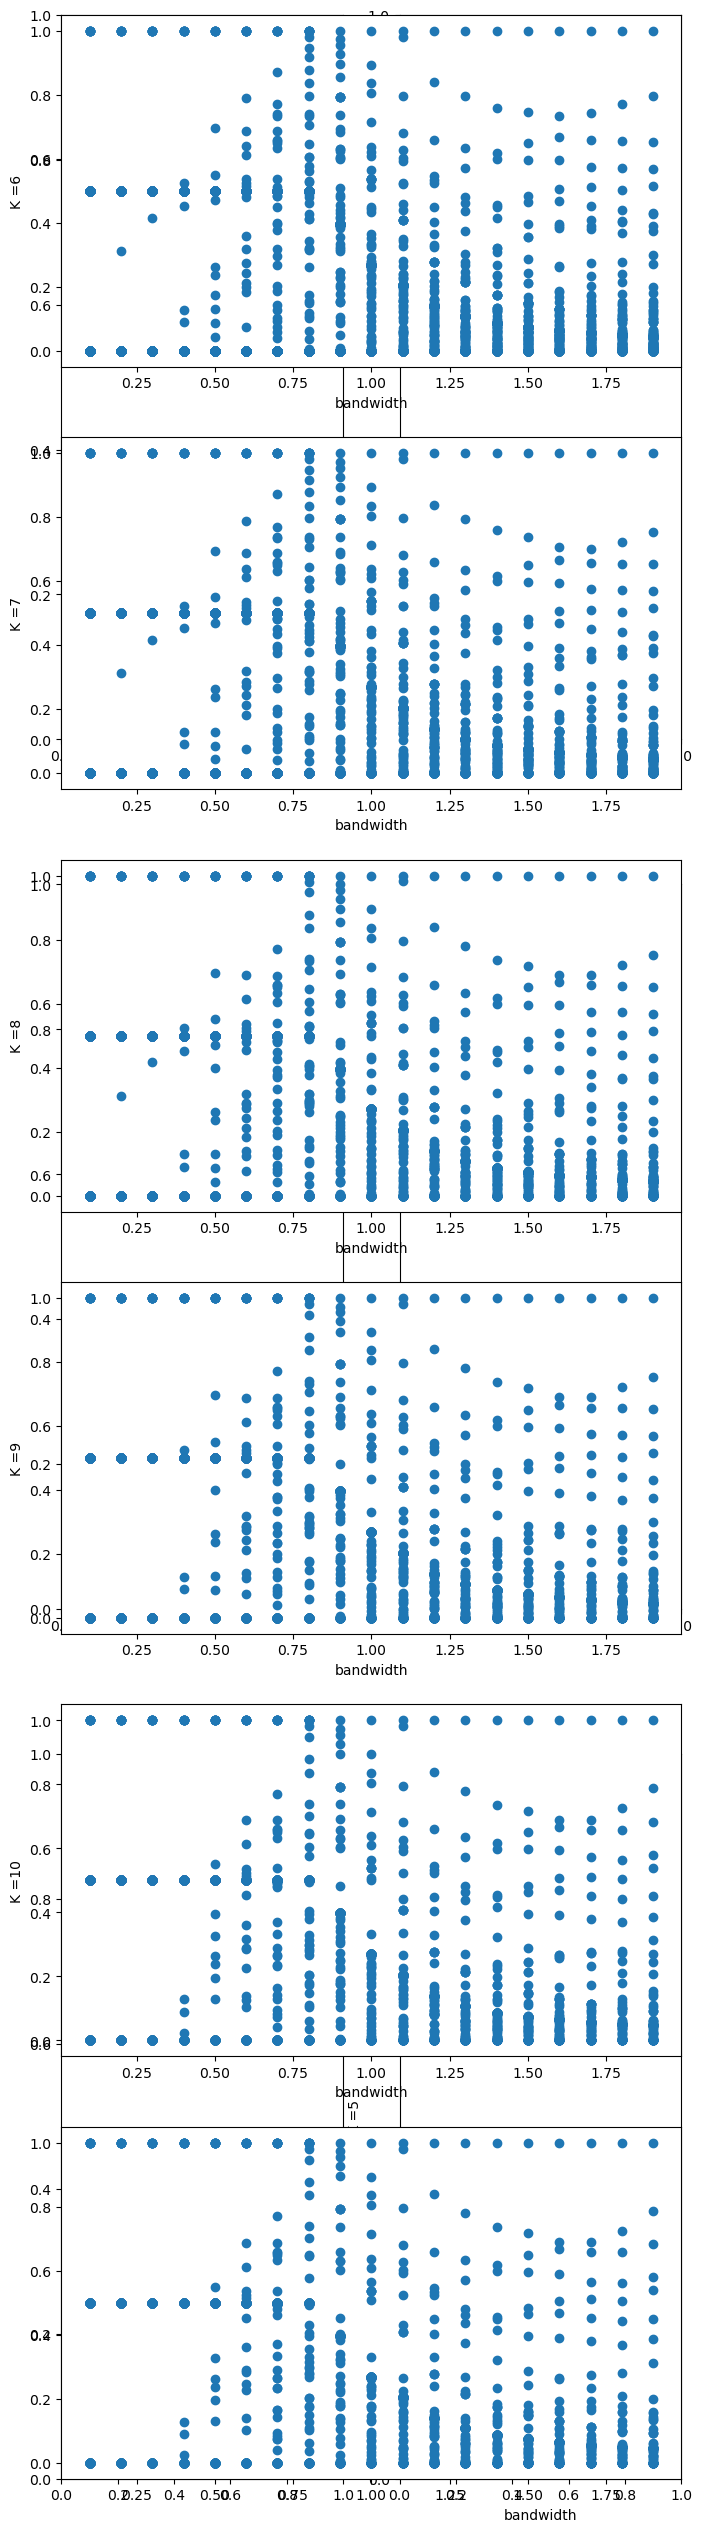

In [23]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

for n_neigh in range(6,12):
    n_diagram = []
    x_diagram = []
    y_diagram = []
    bandwidth_values = [0.1, 2, 0.1]
    bandwidth = bandwidth_values[0]

    while bandwidth < bandwidth_values[1]:
        ex2 = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="knn",
        density_type="KDE",
        kde_params = {"bandwidth": bandwidth, "kernel": "epanechnikov"},
        k=n_neigh,
        eps=0.05,
    )
        ex2.fit(data)
        init_clusters = len(ex2.diagram_)
        prominences = np.zeros(init_clusters)
        for i in range(init_clusters):
            prominences[i] = ex2.diagram_[i,0] - ex2.diagram_[i,1]

        ##"Normalizing" prominences
        max_prom = np.max(prominences)
        for i in range(init_clusters):
            prominences[i] /= max_prom

        n_diagram.append(prominences)
        bandwidth += bandwidth_values[2]


    for i in range(len(n_diagram)):
        for j in range(len(n_diagram[i])):
            x_diagram.append(bandwidth_values[0] + i*bandwidth_values[2])
            y_diagram.append(n_diagram[i][j])

    plt.ylabel('K =' + str(n_neigh-1))
    plt.xlabel('bandwidth')
    plt.subplot(6, 1, n_neigh-5)
    plt.scatter(x_diagram, y_diagram)

fig = plt.gcf()
fig.set_size_inches(8, 32)
plt.show()

There are 14 initial clusters


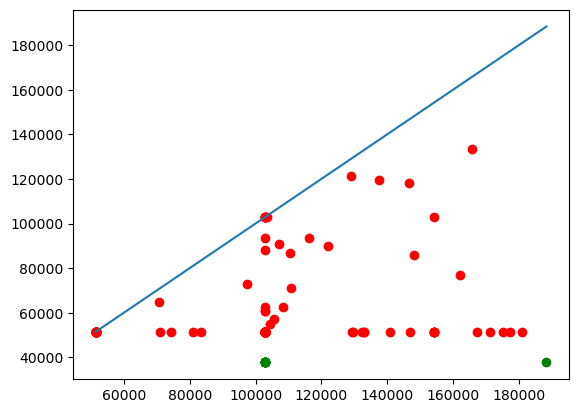

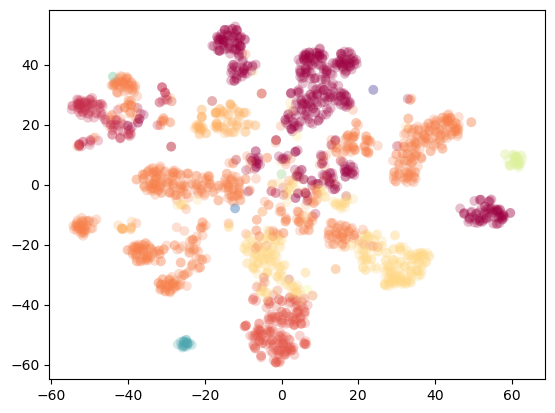

In [24]:
clusterer = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="knn",
        density_type="KDE",
        kde_params = {"bandwidth": 0.9, "kernel": "epanechnikov"},
        n_clusters=14,
        k=9,
    )

clusterer.fit(data)

print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()
color_palette = sns.color_palette('Paired', 100)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
n = clusterer.n_clusters_
labels = clusterer.labels_
norm = plt.Normalize(vmin=0, vmax=n-1)
cmap = plt.cm.Spectral;
plt.scatter(*projection.T, s=50, linewidth=0, c=cmap(norm(labels)), alpha=0.25);
stat = stat_filling(data, clusterer.labels_, 'ToMATo1', stat)

In [25]:
labels = clusterer.labels_
print("silhouette_score", metrics.silhouette_score(data, labels, metric='euclidean'))
print("calinski_harabasz_score", metrics.calinski_harabasz_score(data, labels))
print("davies_bouldin_score", metrics.davies_bouldin_score(data, labels))

silhouette_score -0.09848251277309536
calinski_harabasz_score 46.81569867551686
davies_bouldin_score 1.9911487919498205


# Genie

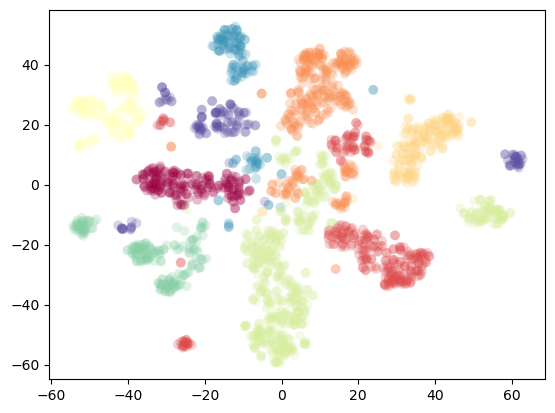

In [26]:
g = genieclust.Genie(n_clusters=9)
labels = g.fit_predict(data)
n = g.n_clusters_
norm = plt.Normalize(vmin=0, vmax=n-1)
cmap = plt.cm.Spectral;
plt.scatter(*projection.T, s=50, linewidth=0, c=cmap(norm(labels)), alpha=0.25);
stat = stat_filling(data, clusterer.labels_, 'Genie', stat)

In [27]:
print("silhouette_score", metrics.silhouette_score(data, labels, metric='euclidean'))
print("calinski_harabasz_score", metrics.calinski_harabasz_score(data, labels))
print("davies_bouldin_score", metrics.davies_bouldin_score(data, labels))

silhouette_score 0.0657097184447089
calinski_harabasz_score 67.01251185431886
davies_bouldin_score 2.961829217101883


# Persistable

Persistable is a good tool for visual analysis, which is easy to use. However, there are some practical advices that may be helpful.

- Choose family of lines, so that they take into account a wide range of components.
- Use log prominance scale to select appropriate line and gap numbers.

In [28]:
p = persistable.Persistable(data, n_neighbors="all")
pi = persistable.PersistableInteractive(p)
port = pi.start_ui(jupyter_mode='inline')

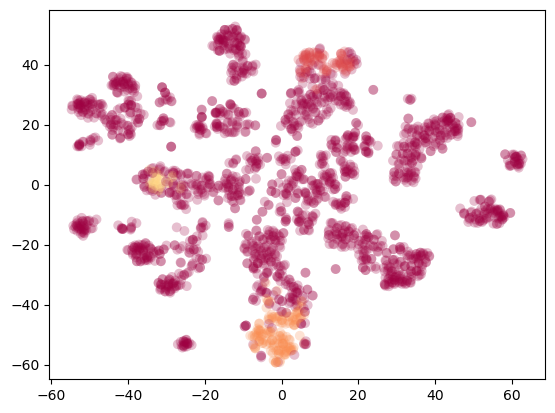

In [30]:
cluster_labels = pi.cluster()
norm = plt.Normalize(vmin=0, vmax=n-1)
cmap = plt.cm.Spectral;
plt.scatter(*projection.T, s=50, linewidth=0, c=cmap(norm(cluster_labels)), alpha=0.25);
stat = stat_filling(data, cluster_labels, 'Persistable', stat)